# Quantization in TFLite
In this assignment you will get to explore quantizing a model in TFLite again. This time some of the code will be missing and you'll need to fill it in. The model we are exploring today is a computer vision model that recognizes hand gestures for the rock, paper, scissors game!

## Set up the problem

### Import packages

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

### Download the dataset

In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'rock_paper_scissors', split=['train[:80%]', 'train[80%:]', 'test'], 
    with_info=True, as_supervised=True)
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteM6R5ZL/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteM6R5ZL/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Build and train a baseline model

In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
63/63 [==============================] - 39s 96ms/step - loss: 0.3069 - accuracy: 0.9196 - val_loss: 0.0961 - val_accuracy: 0.9861
Epoch 2/5
63/63 [==============================] - 7s 87ms/step - loss: 0.0674 - accuracy: 0.9936 - val_loss: 0.0466 - val_accuracy: 0.9960
Epoch 3/5


### Save the baseline model

In [ ]:
ROCK_PAPER_SCISSORS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, ROCK_PAPER_SCISSORS_SAVED_MODEL)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: exp_saved_model/assets


INFO:tensorflow:Assets written to: exp_saved_model/assets


## Now its your turn
### Convert the model to TFLite

Hint: You'll need to use the saved model to generate a converter and then run it. This will only require two lines of code! Isn't TFLite amazing!

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL)
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes
# you will note that this model is too big for our Arduino
# but would work on a mobile phone

8883936

In [ ]:
! ls -ltr /tmp

total 8740
lrwxrwxrwx 1 root root      61 Jun 27 17:14 dap_multiplexer.INFO -> dap_multiplexer.096cec169a72.root.log.INFO.20210627-171459.54
srwxr-xr-x 1 root root       0 Jun 27 17:14 debugger_7viyfmdgw
drwx------ 2 root root    4096 Jun 27 17:14 initgoogle_syslog_dir.0
-rw-r--r-- 1 root root    1435 Jun 27 17:15 dap_multiplexer.096cec169a72.root.log.INFO.20210627-171459.54
drwx------ 2 root root    4096 Jun 27 17:29 tmpzjpvxq_atfds
-rw------- 1 root root     725 Jun 27 17:29 tmpiph96_uu.py
drwxr-xr-x 3 root root    4096 Jun 27 17:30 tfhub_modules
-rw------- 1 root root    5809 Jun 27 17:30 tmpejpo4f47.py
-rw------- 1 root root    3541 Jun 27 17:30 tmp7bywht3_.py
-rw------- 1 root root    2585 Jun 27 17:30 tmp203jqke7.py
-rw------- 1 root root     866 Jun 27 17:30 tmpdzh2s_kv.py
-rw------- 1 root root     866 Jun 27 17:30 tmpii5dksdn.py
-rw------- 1 root root    2458 Jun 27 17:31 tmpj196oo8d.py
-rw------- 1 root root    1080 Jun 27 17:31 tmpqye9jdey.py
-rw------- 1 root root     461 J

### Test the model

Hint: You'll need to definite an Interpreter that we can use to run the model. Again TFLite being amazing will only require you to write one line of code!

In [ ]:
# Load TFLite model and allocate tensors.
TFLITE_MODEL_FILE = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# import pdb; pdb.set_trace()
# This will tell you how many of the predictions were correct
score = 0
for item in range(0,99):
  prediction=np.argmax(predictions[item]) # paper, rock, scissors, get the index with highest prob.
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("\nOut of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


Out of 100 predictions I got 85 correct


## Plot the results

To explore the results a little more we've include the plotting code below which will help you visualize which images the model is getting correct and incorrect. **If you'd like to improve the model's performance we suggest modifying the code in "Build and train a baseline model." Some ideas include, training for more epochs, choosing a different model architecture, and changing the optimizer. If you are feeling ambitious we'd suggest trying out quantization aware training!**

In [ ]:
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    # import pdb; pdb.set_trace()
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

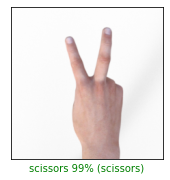

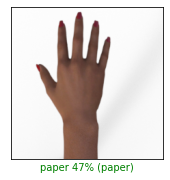

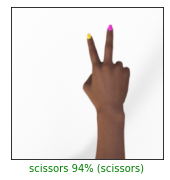

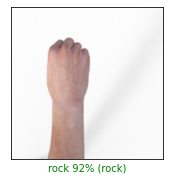

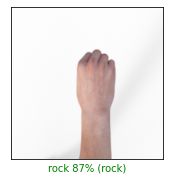

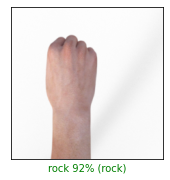

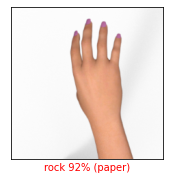

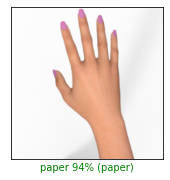

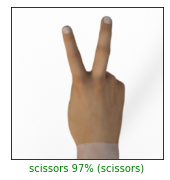

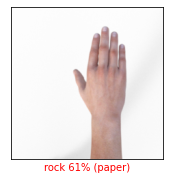

In [ ]:
#@title Visualize the outputs { run: "auto" }
max_index = 10 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

#Further Study

We are going to dive a little deeper into the ideas behind post-training quantization and optimization in the next section. That said, if you'd like to check out how these steps are implemetned in Tensorflow Lite, please check out the user guides at https://www.tensorflow.org/lite/performance/post_training_quantization.